In [ ]:

# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set paths

damaged_path = '/content/drive/MyDrive/garlic_yolo_sort/damaged_garlic'
healthy_path = '/content/drive/MyDrive/garlic_yolo_sort/healthy_garlic'
background_path = '/content/drive/MyDrive/garlic_yolo_sort/back_ground'
base_dir = '/tmp/garlic_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


In [ ]:

# Create directories with 3 classes
def create_directories():
    for path in [train_dir, val_dir]:
        if os.path.exists(path):
            shutil.rmtree(path)
        for class_name in ['damaged', 'healthy', 'back_ground']:
            os.makedirs(os.path.join(path, class_name), exist_ok=True)
create_directories()

In [ ]:
# Function to split and copy images (80-10-10 split)

def split_copy_images(source_path, class_name):
    files = [f for f in os.listdir(source_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    train_files, val_files = train_test_split(files, test_size=0.3, random_state=42)


    def copy_files(file_list, dest_dir):
        for f in file_list:
            shutil.copy(os.path.join(source_path, f),
                        os.path.join(dest_dir, class_name, f))

    copy_files(train_files, train_dir)
    copy_files(val_files, val_dir)


# Split and copy for all 3 classes
split_copy_images(damaged_path, 'damaged')
split_copy_images(healthy_path, 'healthy')
split_copy_images(background_path, 'back_ground')

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = "/content/drive/MyDrive/garlic_yolo_sort"
damaged_path = os.path.join(base_dir, "damaged_garlic")
healthy_path = os.path.join(base_dir, "healthy_garlic")
background_path = os.path.join(base_dir, "back_ground")

# Create train and val directories
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")  # Using 'test' instead of 'val' to match your structure
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

def split_copy_images(source_path, class_name):
    # Create class subdirectories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Get image files
    files = [f for f in os.listdir(source_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split 70-30
    train_files, val_files = train_test_split(files, test_size=0.3, random_state=42)

    def copy_files(file_list, dest_dir):
        for f in file_list:
            shutil.copy(os.path.join(source_path, f),
                       os.path.join(dest_dir, f))  # Removed class_name from destination path

    copy_files(train_files, os.path.join(train_dir, class_name))
    copy_files(val_files, os.path.join(val_dir, class_name))

# Split and copy for all 3 classes
split_copy_images(damaged_path, 'damaged_garlic')  # Changed to match your folder names
split_copy_images(healthy_path, 'healthy_garlic')
split_copy_images(background_path, 'back_ground')

# Verify counts
print("Verification:")
for class_name in ['damaged_garlic', 'healthy_garlic', 'back_ground']:
    train_count = len(os.listdir(os.path.join(train_dir, class_name)))
    val_count = len(os.listdir(os.path.join(val_dir, class_name)))
    print(f"{class_name}: Train={train_count}, Test={val_count} ({(val_count/(train_count+val_count))*100:.1f}% test)")

Verification:
damaged_garlic: Train=490, Test=210 (30.0% test)
healthy_garlic: Train=674, Test=290 (30.1% test)
back_ground: Train=490, Test=210 (30.0% test)


In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
import os

# 1. Define paths
base_dir = "/content/drive/MyDrive/garlic_yolo_sort"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")  # Using 'test' as validation

# 2. Create YAML configuration file
yaml_content = f"""
train: {train_dir}
val: {val_dir}

names:
  0: healthy_garlic
  1: damaged_garlic
  2: back_ground
"""

yaml_path = os.path.join(base_dir, "garlic_classification.yaml")
with open(yaml_path, 'w') as f:
    f.write(yaml_content.strip())

print("YAML configuration created at:", yaml_path)



YAML configuration created at: /content/drive/MyDrive/garlic_yolo_sort/garlic_classification.yaml


In [ ]:
# 3. Initialize YOLOv8 classification model
model = YOLO('yolov8n-cls.pt')  # Nano version (fastest)

# 4. Train the model
results = model.train(
    data=yaml_path,
    epochs=50,
    batch=16,
    imgsz=224,
    optimizer="Adam",
    lr0=0.001,
    device="0",  # Use GPU
    name="garlic_yolo_sort",
    seed=42,
    hsv_h=0.015,  # Color augmentation
    hsv_s=0.7,
    hsv_v=0.4,
    fliplr=0.5,   # Horizontal flip
)

print("✅ Training Completed!")

# 5. Evaluate model performance
print("\nEvaluating model...")
metrics = model.val()  # Validate on test set
print(f"Top-1 Accuracy: {metrics.top1:.2f}%")
print(f"Top-5 Accuracy: {metrics.top5:.2f}%")

# 6. Sample predictions
print("\nTesting on sample images...")
sample_images = [
    os.path.join(val_dir, "healthy_garlic", os.listdir(os.path.join(val_dir, "healthy_garlic"))[0]),
    os.path.join(val_dir, "damaged_garlic", os.listdir(os.path.join(val_dir, "damaged_garlic"))[0]),
    os.path.join(val_dir, "back_ground", os.listdir(os.path.join(val_dir, "back_ground"))[0])
]

for img_path in sample_images:
    results = model.predict(img_path)
    print(f"\nImage: {os.path.basename(img_path)}")
    print(f"Predicted: {results[0].names[results[0].probs.top1]} (Confidence: {results[0].probs.top1conf:.2f})")
    results[0].show()  # Display prediction

# 7. Save best model
best_model_path = os.path.join(base_dir, "best_garlic_classifier.pt")
model.export(format="onnx")  # Export to ONNX format
os.rename("runs/classify/garlic_classifier/weights/best.onnx", best_model_path.replace('.pt', '.onnx'))
print(f"\nBest model saved to: {best_model_path}")

100%|██████████| 5.31M/5.31M [00:00<00:00, 95.2MB/s]


Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/drive/MyDrive/garlic_yolo_sort/garlic_classification.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=garlic_yolo_sort, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

RuntimeError: Dataset '/content/drive/MyDrive/garlic_yolo_sort/garlic_classification.yaml' error ❌ [Errno 20] Not a directory: '/content/drive/MyDrive/garlic_yolo_sort/garlic_classification.yaml/train'

In [ ]:
# Data augmentation and preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Create data generators
# BATCH_SIZE = 16
# IMG_SIZE = (224, 224)

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='binary'
# )

# val_generator = val_test_datagen.flow_from_directory(
#     val_dir,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     shuffle=False
# )

# test_generator = val_test_datagen.flow_from_directory(
#     test_dir,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     shuffle=False
# )

BATCH_SIZE = 32  # Increased from 16 for better GPU utilization
IMG_SIZE = (224, 224)

# Define class order explicitly (alphabetical by default, but explicit is safer)
CLASS_NAMES = sorted(['back_ground', 'damaged', 'healthy'])  # Ensures consistent ordering

# Training generator with more aggressive augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True,
    seed=42,  # For reproducibility
    interpolation='bilinear'  # Default but explicit
)

# Validation generator with fixed order
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False,
    interpolation='bilinear'
)

# Test generator with additional metrics
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False,
    interpolation='bilinear'
)

# Add verification step
print("\nClass mappings:")
print(f"Train: {train_generator.class_indices}")
print(f"Validation: {val_generator.class_indices}")
print(f"Test: {test_generator.class_indices}")

# Verify batch shapes
sample_batch = next(train_generator)
print(f"\nBatch shape: {sample_batch[0].shape}")
print(f"Label shape: {sample_batch[1].shape}")

Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.

Class mappings:
Train: {'back_ground': 0, 'damaged': 1, 'healthy': 2}
Validation: {'back_ground': 0, 'damaged': 1, 'healthy': 2}
Test: {'back_ground': 0, 'damaged': 1, 'healthy': 2}

Batch shape: (32, 224, 224, 3)
Label shape: (32, 3)


In [ ]:
# Create EfficientNetB0 model
# def create_model():
#     base_model = EfficientNetB0(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224, 224, 3)
#     )
#     base_model.trainable = False  # Freeze base layers initially

#     inputs = tf.keras.Input(shape=(224, 224, 3))
#     x = base_model(inputs, training=False)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs, outputs)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# model = create_model()

def create_model():
    # 1. Base model remains the same
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    # 2. Modified classification head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Increased capacity
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)  # 3-class output

    # 3. Updated compilation
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',  # Changed loss
        metrics=['accuracy']
    )
    return model

model = create_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

# Callbacks
# checkpoint = ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )

# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Updated ModelCheckpoint without save_format
checkpoint = ModelCheckpoint(
    'best_3class_model.h5',  # .h5 extension implies HDF5 format
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

# Improved EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)



Augmenting damaged...
Augmenting healthy...
Augmenting back_ground...
Class damaged now has 2880 training images
Class healthy now has 2880 training images
Class back_ground now has 2879 training images
Found 8639 images belonging to 3 classes.


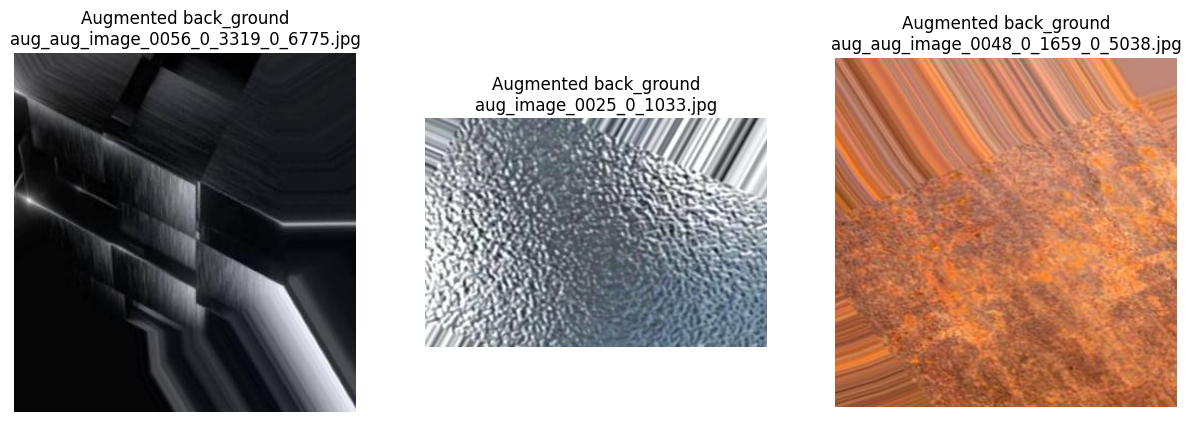

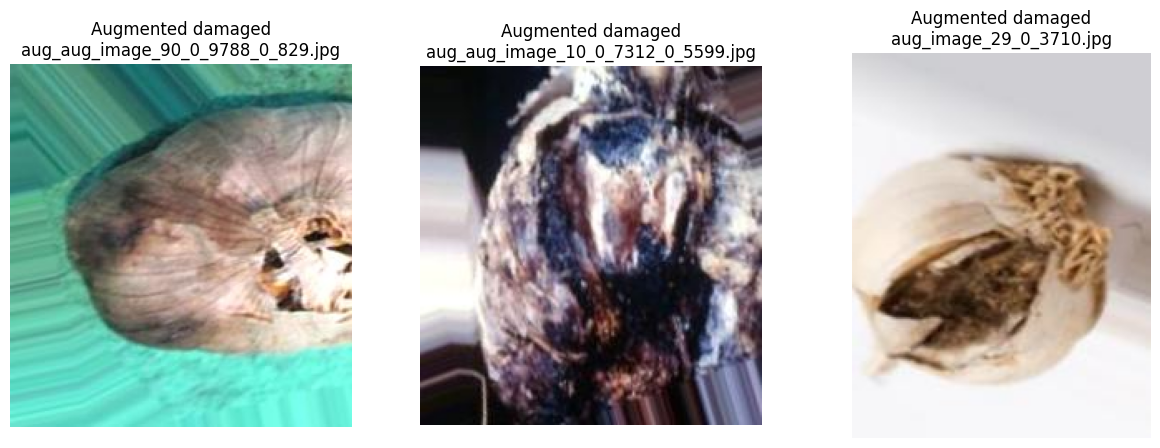

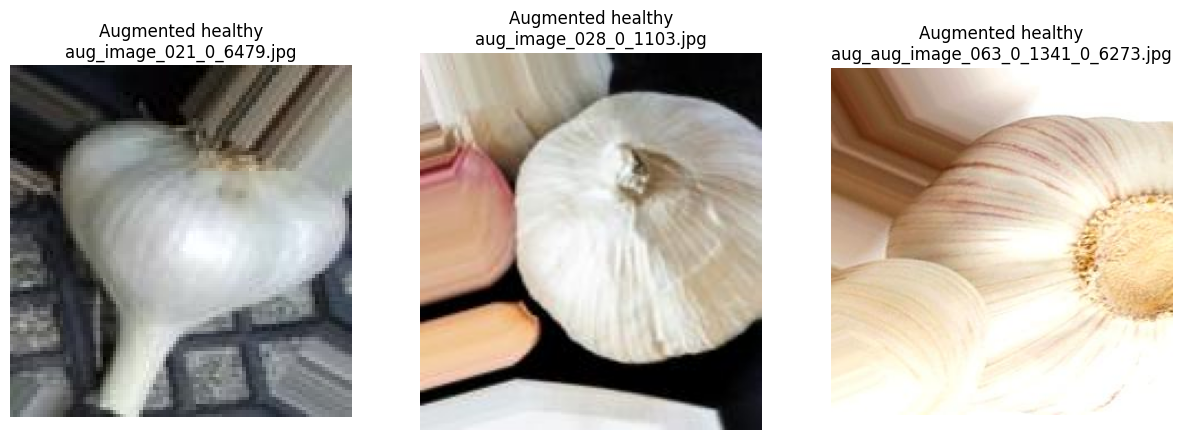

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation configuration
AUGMENTATION_FACTOR = 5  # Generate 5 augmented versions per original image

# Create separate generator for augmentation saving
save_augmented_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

def augment_and_save(class_path):
    """Generate and save augmented images for a class"""
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_name in images:
        img_path = os.path.join(class_path, img_name)

        # Load image
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension

        # Generate augmented images
        save_prefix = f"aug_{os.path.splitext(img_name)[0]}"
        i = 0
        for batch in save_augmented_gen.flow(
            img_array,
            batch_size=1,
            save_to_dir=class_path,
            save_prefix=save_prefix,
            save_format='jpg'
        ):
            i += 1
            if i >= AUGMENTATION_FACTOR:
                break

# Apply augmentation to all classes in training directory
for class_name in ['damaged', 'healthy', 'back_ground']:
    class_path = os.path.join(train_dir, class_name)
    print(f"Augmenting {class_name}...")
    augment_and_save(class_path)

# Verify new dataset sizes
for class_name in ['damaged', 'healthy', 'back_ground']:
    class_path = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class {class_name} now has {num_images} training images")

# Create new generators without on-the-fly augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

# Visualize augmented samples
def plot_augmented_samples(class_name, num_samples=3):
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.startswith('aug_')][:num_samples]

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Augmented {class_name}\n{img_name}")
        plt.axis('off')
    plt.show()

# Plot examples for each class
for class_name in CLASS_NAMES:
    plot_augmented_samples(class_name)

Class Indices: {'back_ground': 0, 'damaged': 1, 'healthy': 2}
Training samples: 8639
Validation samples: 30
Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 9.2210e-04
Epoch 1: val_accuracy did not improve from 1.00000
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 1.0000 - loss: 9.2121e-04 - val_accuracy: 1.0000 - val_loss: 0.0122
Epoch 2/20
  1/269 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 1.0000 - loss: 8.4084e-05
Epoch 2: val_accuracy did not improve from 1.00000
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 1.0000 - loss: 8.4084e-05 - val_accuracy: 1.0000 - val_loss: 0.0122
Epoch 3/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 4.4420e-04
Epoch 3: val_accuracy did not improve from 1.00000
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 1.0000 - loss: 4.4421e-04 - val_accuracy: 1.0000 - val_loss: 0.0205
Epoch 4/20
  1/269 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 1.0000 - loss: 9.9497e-06
Epoch 4: val_accuracy did not improve from 1.00000
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 9.9497e-06 - val_accuracy: 1.0000 - val_loss: 0.0209
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 5.0135e-04
Epoch 5: val_accuracy did not improve from 1.00000
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 1.0000 - loss: 5.0156e-04 - val_accuracy: 1.0000 - val_loss: 0.0119
Epoch 6/20
  1/269 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 1.0000 - loss: 2.9866e-04
Epoch 6: val_accuracy did not improve from 1.00000
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 1.0000 - loss: 2.9866

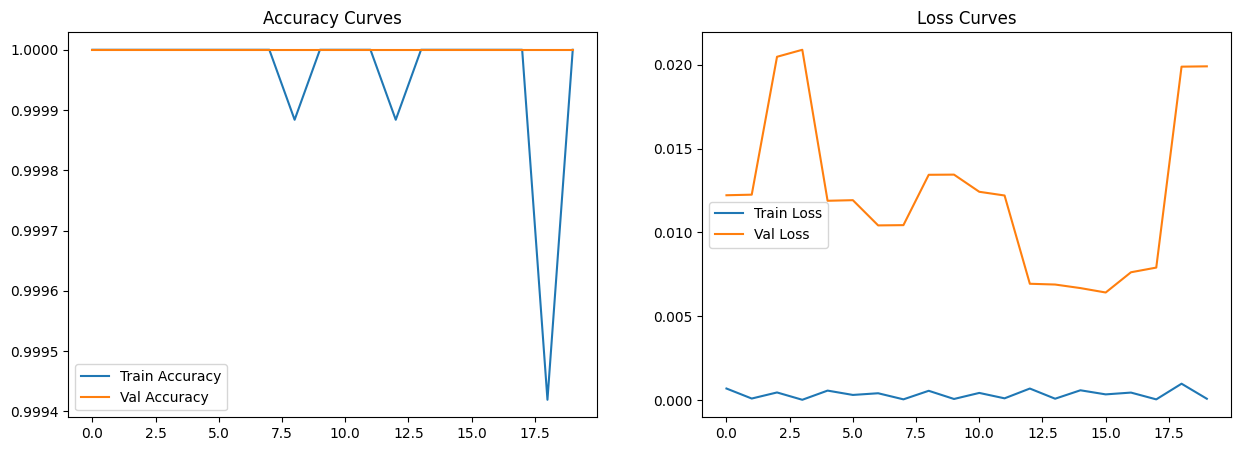

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 1.0000 - loss: 0.0012

Test Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step

Classification Report:
              precision    recall  f1-score   support

 back_ground       1.00      1.00      1.00        10
     damaged       1.00      1.00      1.00        10
     healthy       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



'/content/drive/MyDrive/garlic_classifier_3class.h5'

In [ ]:
# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=30,
#     validation_data=val_generator,
#     callbacks=[checkpoint, early_stop]
# )

# First verify class mappings
print("Class Indices:", train_generator.class_indices)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,# 1440//32=45 steps (if 80*6=480 per class)
    epochs=20, # Increased for potential longer training
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop],
    class_weight={0: 1.0, 1: 1.0, 2: 1.0}  # Adjust if classes are imbalanced

)
# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.2%}")

# Generate predictions
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Save final model to Drive
import shutil

shutil.copy('best_3class_model.h5', '/content/drive/MyDrive/garlic_classifier_3class.h5')


In [ ]:
# Load best weights and save final model
model.load_weights('best_model.h5')
model.save('garlic_classifier.h5')

# Save to Google Drive
from google.colab import files
!cp garlic_classifier.h5 '/content/drive/MyDrive/garlic_classifier.h5'

# Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.2%}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9458 - loss: 0.1428 

Test Accuracy: 95.00%


In [ ]:
# Generate predictions
y_pred = (model.predict(test_generator) > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



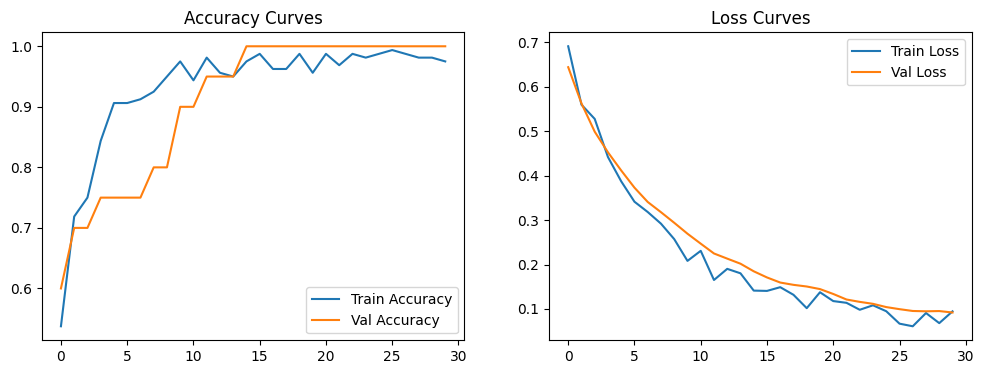

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

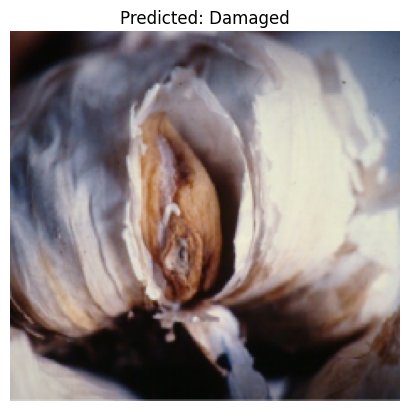

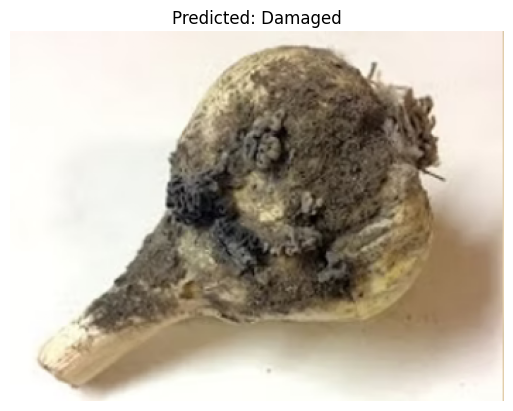

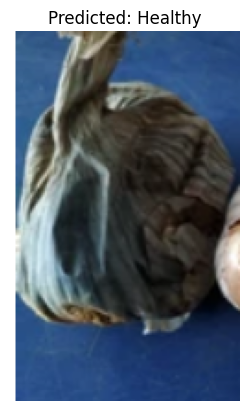

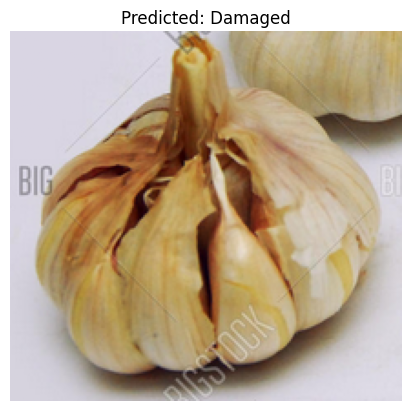

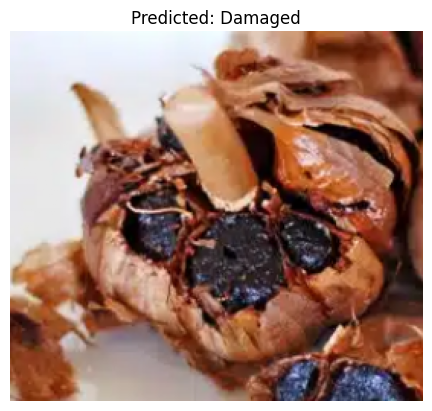

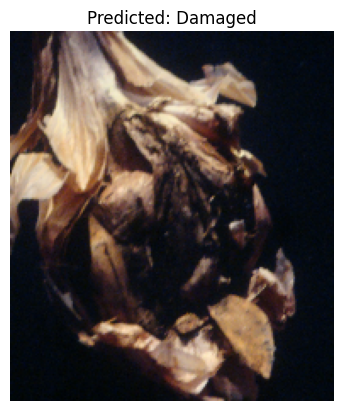

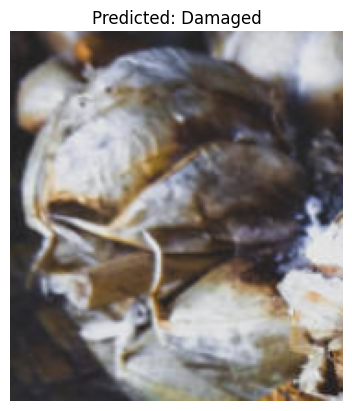

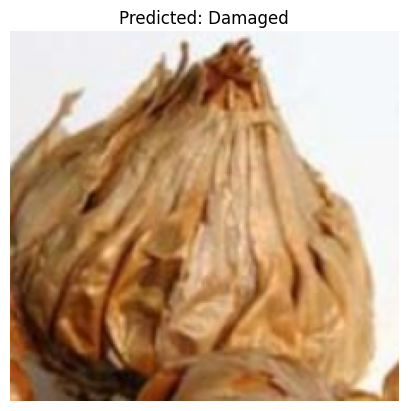

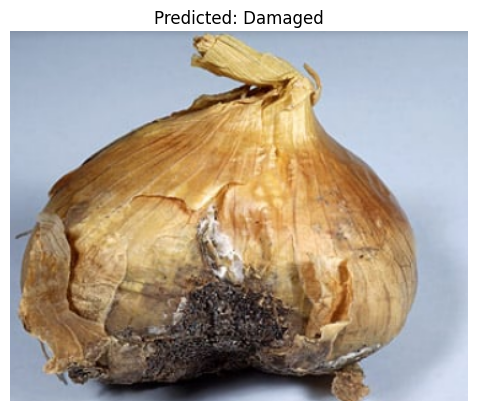

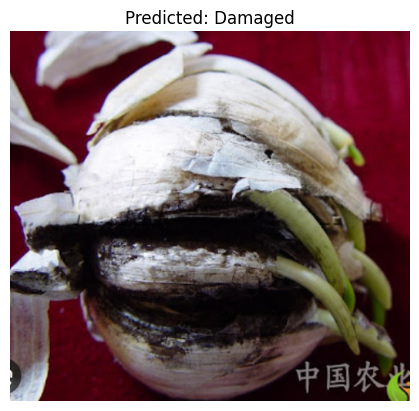

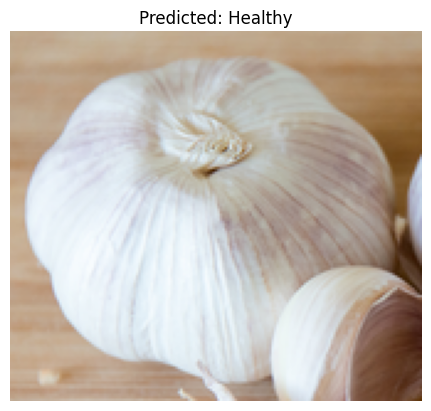

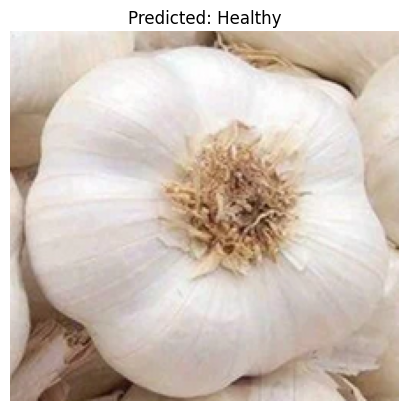

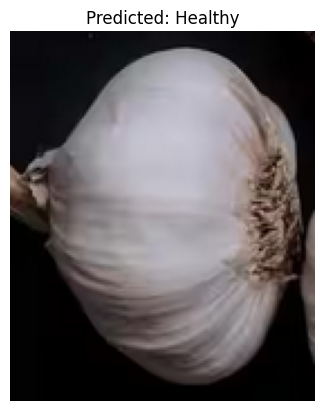

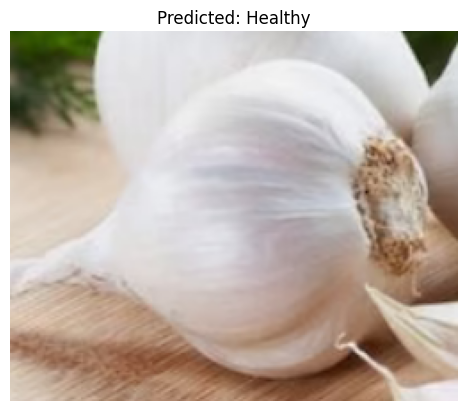

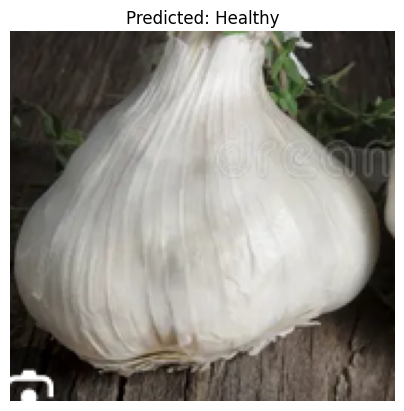

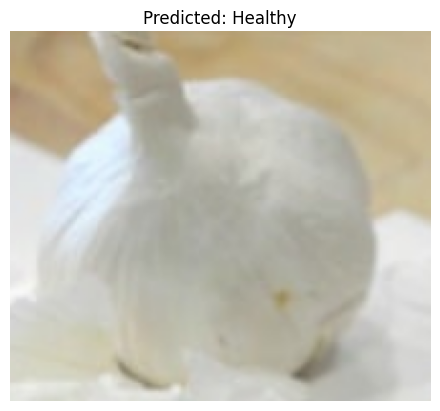

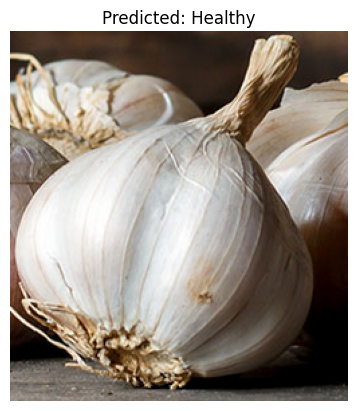

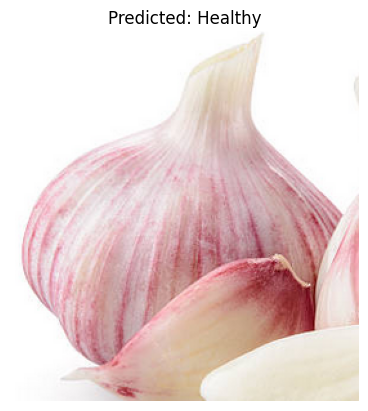

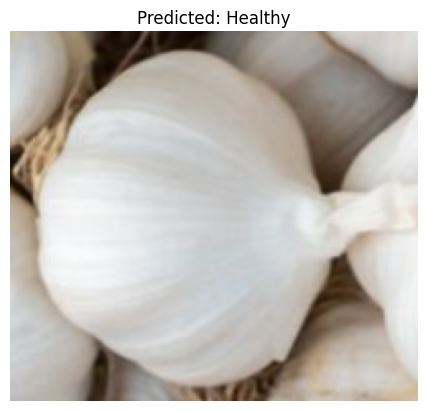

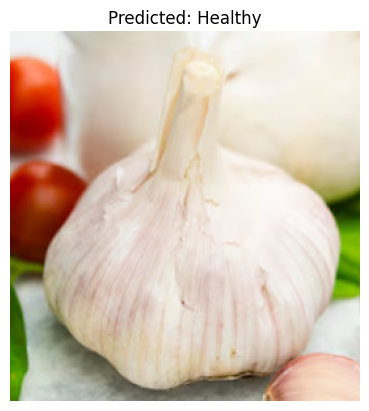

In [ ]:
# prompt: show the image prediction on test data

import matplotlib.pyplot as plt
import numpy as np

# Assuming test_generator and y_pred are already defined from the previous code

# Get the filenames from the test generator
filenames = test_generator.filenames

# Get the predicted classes
predicted_classes = np.round(y_pred).flatten()  # Convert probabilities to class labels (0 or 1)


# Iterate through the test data and display images with predictions
for i in range(len(filenames)):
  img_path = os.path.join(test_dir, filenames[i])
  img = plt.imread(img_path)
  plt.imshow(img)
  plt.title(f"Predicted: {'Damaged' if predicted_classes[i] == 0 else 'Healthy'}")
  plt.axis('off')
  plt.show()


In [ ]:
# prompt: i got to see that the class prediction is opposite ie the prediction is showing damaged for all healthy images and healthy for all damaged images ,why is it caused how to solve it

print(train_generator.class_indices)  # Check the mapping between class names and labels


{'damaged': 0, 'healthy': 1}


{'damaged': 0, 'healthy': 1}


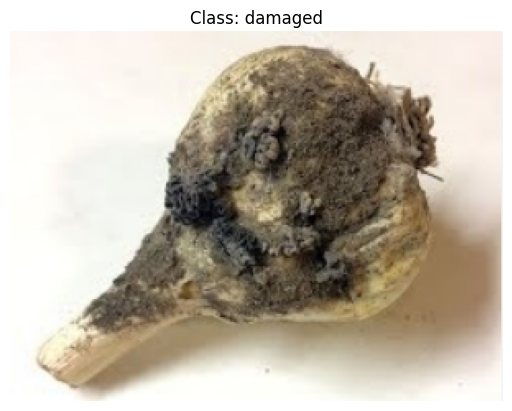

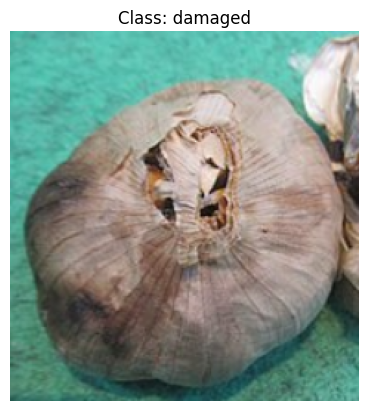

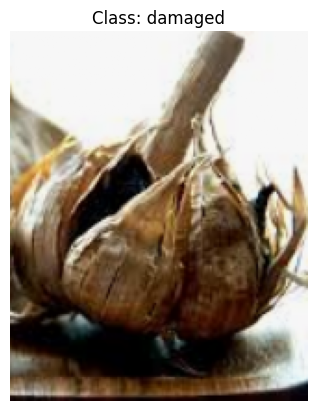

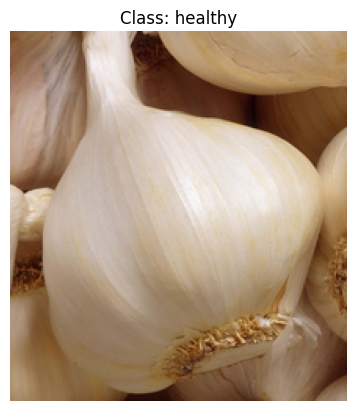

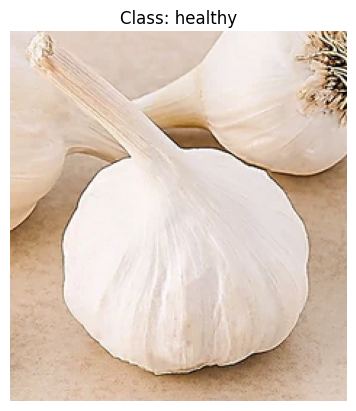

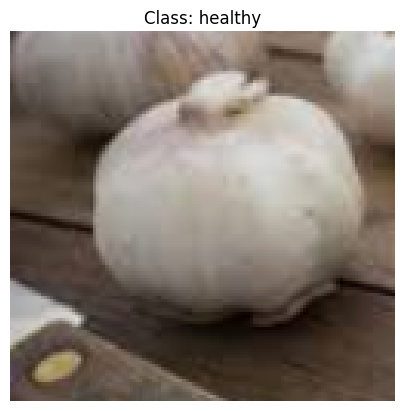

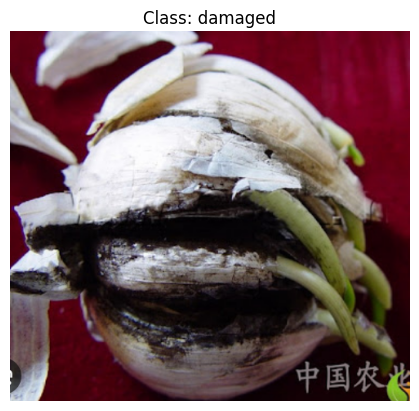

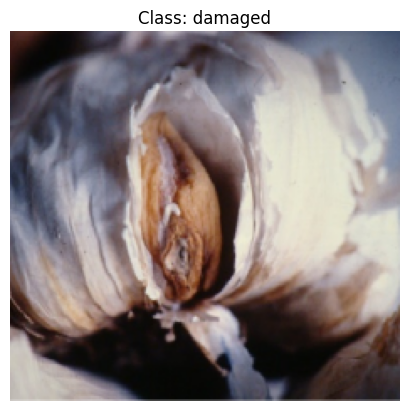

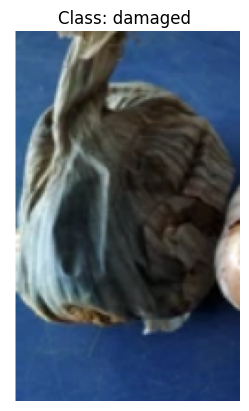

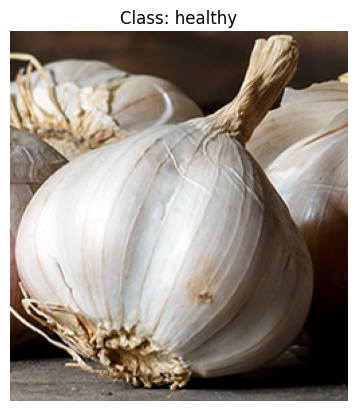

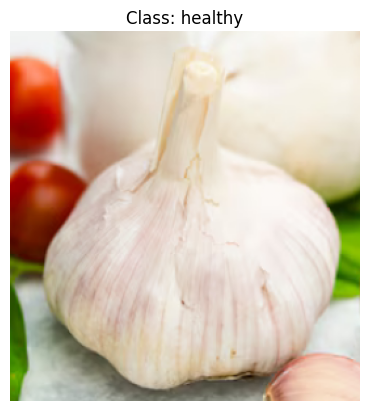

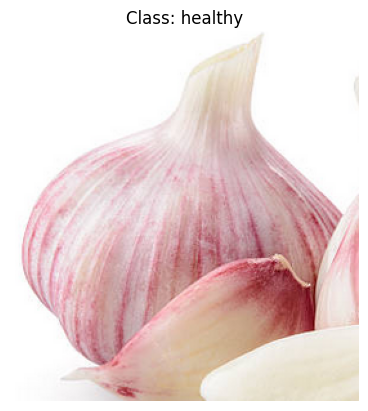

In [ ]:
# prompt: show the labels of few images in the train and test data used with images

# Print class indices to show the mapping between class names and labels
print(train_generator.class_indices)

# Display a few image labels from the training data
import matplotlib.pyplot as plt
import os

# Assuming train_dir and train_generator are already defined
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    for filename in os.listdir(class_dir)[:3]: # Display first 3 images of each class
        img_path = os.path.join(class_dir, filename)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis("off")
        plt.show()

# Display a few image labels from the test data
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    for filename in os.listdir(class_dir)[:3]:  # Display first 3 images per class
        img_path = os.path.join(class_dir, filename)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis("off")
        plt.show()
